# Firecrown YAML Interface

Following the tutorials from the firecrown team [here](https://firecrown.readthedocs.io/en/latest/_static/inferred_zdist.html), 
this notebook tests the creation of firecrown data-vectors and likelihoods using the YAML interface.

In [142]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from firecrown.metadata_types import Galaxies, InferredGalaxyZDist
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBin, LinearGrid1D
from firecrown.utils import base_model_to_yaml, base_model_from_yaml

import numpy as np
import matplotlib.pyplot as plt
import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a inferred galaxy redshift distribution data-vector

First let's create these objects and then convert them to YAML files

In [43]:
z = LinearGrid1D(start=0.01, end=0.5, num=50)
bin0 = ZDistLSSTSRDBin(
    zpl=0.1,
    zpu=0.2,
    sigma_z=0.03,
    z=z,
    bin_name="bin0",
    measurements={Galaxies.COUNTS},
)

bin0_yaml = base_model_to_yaml(bin0)
print(bin0_yaml)

zpl: 0.1
zpu: 0.2
sigma_z: 0.03
z:
  start: 0.01
  end: 0.5
  num: 50
bin_name: bin0
measurements:
- subject: Galaxies
  property: COUNTS
use_autoknot: false
autoknots_reltol: 0.0001
autoknots_abstol: 1.0e-15



Or maybe we need to create a collection for it to work?

In [44]:
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBinCollection

In [45]:
bin_collect = ZDistLSSTSRDBinCollection(
    alpha=0.1,
    beta=0.2,
    z0=0.3,
    bins=[bin0],
    )

In [46]:
zdist = bin_collect.generate()

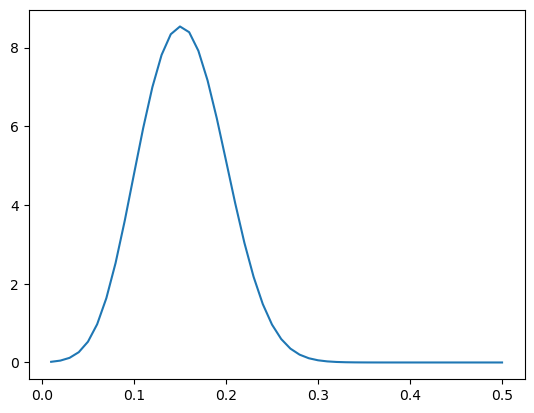

In [47]:
plt.plot(zdist[0].z, zdist[0].dndz)

In [81]:
import sys
from pathlib import Path

# Add the CosmoAPI directory to the Python path
sys.path.append("../CosmoAPI")

# Import the load_nz function
from two_point_functions.nz_loader import load_nz

# Example usage
yaml_data = {
    "nz_type": "LSST_Y10_LENS_BIN_COLLECTION"
}
result = load_nz(yaml_data)

print(base_model_to_yaml(result))

alpha: 0.9
beta: 2.0
z0: 0.28
bins:
- zpl: 0.2
  zpu: 0.30000000000000004
  sigma_z: 0.03
  z:
    values:
    - 0.0
    - 3.0
  bin_name: lens_0.2_0.3_y10
  measurements:
  - subject: Galaxies
    property: COUNTS
  use_autoknot: true
  autoknots_reltol: 1.0e-05
  autoknots_abstol: 1.0e-15
- zpl: 0.30000000000000004
  zpu: 0.4
  sigma_z: 0.03
  z:
    values:
    - 0.0
    - 3.0
  bin_name: lens_0.3_0.4_y10
  measurements:
  - subject: Galaxies
    property: COUNTS
  use_autoknot: true
  autoknots_reltol: 1.0e-05
  autoknots_abstol: 1.0e-15
- zpl: 0.4
  zpu: 0.5
  sigma_z: 0.03
  z:
    values:
    - 0.0
    - 3.0
  bin_name: lens_0.4_0.5_y10
  measurements:
  - subject: Galaxies
    property: COUNTS
  use_autoknot: true
  autoknots_reltol: 1.0e-05
  autoknots_abstol: 1.0e-15
- zpl: 0.5
  zpu: 0.6000000000000001
  sigma_z: 0.03
  z:
    values:
    - 0.0
    - 3.0
  bin_name: lens_0.5_0.6_y10
  measurements:
  - subject: Galaxies
    property: COUNTS
  use_autoknot: true
  autoknots_r

# 2pt functions playground

## Generating the metadata

In [82]:
from firecrown.generators.inferred_galaxy_zdist import (
    LSST_Y1_LENS_BIN_COLLECTION,
    LSST_Y1_SOURCE_BIN_COLLECTION,
)

count_bins = LSST_Y1_LENS_BIN_COLLECTION.generate()
shear_bins = LSST_Y1_SOURCE_BIN_COLLECTION.generate()
all_y1_bins = count_bins + shear_bins

In [83]:
import numpy as np
from firecrown.metadata_functions import make_all_photoz_bin_combinations, TwoPointHarmonic, TwoPointReal

all_two_point_xy = make_all_photoz_bin_combinations(all_y1_bins)
ells = np.unique(np.geomspace(2, 2000, 128).astype(int))
all_two_point_cells = [TwoPointHarmonic(XY=xy, ells=ells) for xy in all_two_point_xy]

## Defining the 2pt factories

In [85]:
import firecrown.likelihood.weak_lensing as wl
import firecrown.likelihood.number_counts as nc
import firecrown.likelihood.two_point as tp

# WeakLensing systematics -- global
ia_systematic = wl.LinearAlignmentSystematicFactory()
# WeakLensing systematics -- per-bin
wl_photoz = wl.PhotoZShiftFactory()
wl_mult_bias = wl.MultiplicativeShearBiasFactory()

# NumberCounts systematics -- global
# As for Firecrown 1.8.0a0, we do not have any global systematics for number counts
# NumberCounts systematics -- per-bin
nc_photoz = nc.PhotoZShiftFactory()

wlf = wl.WeakLensingFactory(
    per_bin_systematics=[wl_mult_bias, wl_photoz],
    global_systematics=[ia_systematic],
)
ncf = nc.NumberCountsFactory(
    per_bin_systematics=[nc_photoz],
    global_systematics=[],
)

In [86]:
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_cells,
    wl_factory=wlf,
    nc_factory=ncf,
)

In [170]:
test_wlf = base_model_to_yaml(wlf)
print(type(test_wlf))

<class 'str'>


## loading factories from yaml

In [155]:
import yaml
def load_yaml_file(file_path):
    """Helper function to load a YAML file"""
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

In [176]:
config = load_yaml_file("../test.yaml")
probes = config.get("probes", [])

In [177]:
nzs = []
for probe, propr in config['probes'].items():
    if 'nz_type' in propr:
        print(propr['nz_type'])
        nzs += load_nz(propr)

LSST_Y1_SOURCE_BIN_COLLECTION
LSST_Y1_LENS_BIN_COLLECTION


In [171]:
def load_systematics_factory(probe_systematics):
    """
    Dynamically load a class based on the systematics 'type' specified in the YAML file.

    Args:
        systematics_type (str): The 'type' field from the YAML specifying which factory to use.

    Returns:
        The loaded class from the firecrown library.
    """
    # Define base module path based on firecrown's library structure
    base_module = "firecrown.likelihood"
    
    # Mapping of known factories to their submodules
    type_to_submodule = {
        'WeakLensingFactory': 'weak_lensing',
        'NumberCountsFactory': 'number_counts',
        # Add other mappings as needed, or consider an automatic lookup if patterns are consistent
    }

    systematics_type = probe_systematics['type']
    # Get the submodule for the type
    submodule = type_to_submodule.get(systematics_type)
    
    if submodule is None:
        raise ImportError(f"Unknown systematics type: {systematics_type}")
    
    # Construct the full module path
    module_path = f"{base_module}.{submodule}"
    
    try:
        # Dynamically import the module
        module = importlib.import_module(module_path)
        # Get the class from the module
        factory_class = getattr(module, systematics_type)
        # copy the systematics dictionary
        systematics_yaml = probe_systematics.copy()
        # remove the type key
        del systematics_yaml['type']
        # instantiate the factory
        factory = base_model_from_yaml(factory_class, yaml.dump(systematics_yaml))
        return factory
    except ImportError as e:
        raise ImportError(f"Could not import module {module_path}: {e}")
    except AttributeError as e:
        raise AttributeError(f"Class '{systematics_type}' not found in module {module_path}: {e}")

In [179]:
for p in probes:
    probes[p]['loaded_systematics'] = load_systematics_factory(probes[p]['systematics'])
    

In [181]:
#FIXME: We have to implement this in the yaml
ells = np.unique(np.geomspace(2, 2000, 128).astype(int))

In [175]:
probes

{'source': {'function': 'TwoPointHarmonic',
  'nz_type': 'LSST_Y1_SOURCE_BIN_COLLECTION',
  'systematics': {'type': 'WeakLensingFactory',
   'per_bin_systematics': [{'type': 'MultiplicativeShearBiasFactory'},
    {'type': 'PhotoZShiftFactory'}],
   'global_systematics': [{'type': 'LinearAlignmentSystematicFactory',
     'alphag': 1.0}]}},
 'lens': {'function': 'TwoPointHarmonic',
  'nz_type': 'LSST_Y1_LENS_BIN_COLLECTION',
  'systematics': {'type': 'NumberCountsFactory',
   'per_bin_systematics': [{'type': 'PhotoZShiftFactory'}],
   'global_systematics': [],
   'loaded_factory': NumberCountsFactory(per_bin_systematics=[PhotoZShiftFactory(type='PhotoZShiftFactory')], global_systematics=[], include_rsd=False)}}}

In [146]:
test_syst_yaml

{'per_bin_systematics': [{'type': 'PhotoZShiftFactory'}],
 'global_systematics': []}

In [168]:
type(probes[p]['systematics'])

dict